In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, Dataset, random_split
from torch.autograd import grad
import matplotlib.pyplot as plt
import pandas as pd
import os
from scipy.stats import wasserstein_distance
from scipy.stats import ks_2samp
import torch.nn.functional as F
import numpy as np 

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import classification_report

In [3]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "mps")

In [4]:
device

device(type='mps')

In [5]:
class MinMaxConstraint:
    """Custom min-max constraint applied manually during forward."""
    def __init__(self, min_value=0.0, max_value=10.0):
        self.min_value = min_value
        self.max_value = max_value

    def __call__(self, w):
        return torch.clamp(w, self.min_value, self.max_value)


def nmodeproduct(x, w, mode):
    """
    n-mode product for 3D tensors.
    x: (N, H, W)
    mode = 1 → w: (H, h)
    mode = 2 → w: (W, w)
    Output: (N, h, W) or (N, H, w)
    """
    if mode == 2:
        # mode-2: multiply along the last dimension
        return torch.matmul(x, w)  # (N, H, W) x (W, w) → (N, H, w)
    else:
        # mode-1: multiply along the second dimension
        x = x.transpose(1, 2)      # (N, W, H)
        x = torch.matmul(x, w)     # (N, W, h)
        x = x.transpose(1, 2)      # (N, h, W)
        return x


class TABL(nn.Module):
    """
    Temporal Attention Augmented Bilinear Layer
    (PyTorch version of Tran et al., 2017)
    """
    def __init__(self, input_dim, output_dim):
        """
        input_dim : tuple (D1, D2)
        output_dim : tuple (d1, d2)
        """
        super(TABL, self).__init__()
        D1, D2 = input_dim
        d1, d2 = output_dim

        # Projection matrices
        self.W1 = nn.Parameter(torch.empty(D1, d1))
        self.W2 = nn.Parameter(torch.empty(D2, d2))
        self.W = nn.Parameter(torch.full((D2, D2), 1.0 / D2))

        # Scalar attention blending coefficient
        self.alpha = nn.Parameter(torch.tensor([0.5]))

        # Bias
        self.bias = nn.Parameter(torch.zeros(1, d1, d2))

        # Initialization
        nn.init.kaiming_uniform_(self.W1, a=5**0.5)
        nn.init.kaiming_uniform_(self.W2, a=5**0.5)

        self.alpha_constraint = MinMaxConstraint(0.0, 1.0)
        self.D2 = D2
        self.output_dim = output_dim

    def forward(self, x):
        """
        x: (N, D1, D2)
        """
        # First mode projection: N x D1 x D2 → N x d1 x D2
        x_proj = nmodeproduct(x, self.W1, 1)

        # Enforce constant (1/D2) on diagonal
        eye = torch.eye(self.D2, device=x.device)
        W = self.W - self.W * eye + eye / self.D2

        # Attention map
        att = torch.matmul(x_proj, W)          # N x d1 x D2
        att = F.softmax(att, dim=-1)

        # Apply attention
        alpha = self.alpha_constraint(self.alpha)
        x_att = alpha * (x_proj * att) + (1 - alpha) * x_proj

        # Second mode projection
        out = nmodeproduct(x_att, self.W2, 2)

        # Add bias
        out = out + self.bias

        # Optional squeeze if second dim = 1
        if self.output_dim[1] == 1:
            out = out.squeeze(-1)

        return out

In [6]:
class TABLClassifier(nn.Module):
    def __init__(
        self,
        s_input_dim,          # (D, T) e.g. (16, 50)
        tabl_hidden_dims,     # [(d1, t1), (d2, t2)]
        hidden_dim,           # MLP hidden dim
        num_classes=3
    ):
        super().__init__()

        # --- State path (TABL layers) ---
        self.tabl1 = TABL(s_input_dim, tabl_hidden_dims[0])
        self.tabl2 = TABL(tabl_hidden_dims[0], tabl_hidden_dims[1])

        # --- MLP classifier ---
        tabl_flat_dim = tabl_hidden_dims[1][0] * tabl_hidden_dims[1][1]

        self.fc1 = nn.Linear(tabl_flat_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc_out = nn.Linear(hidden_dim, num_classes)

        self.relu = nn.ReLU()

    def forward(self, s):
        """
        s: (B, D, T)
        returns: logits (B, 3)
        """

        # TABL feature extraction
        s = self.tabl1(s)
        s = self.tabl2(s)

        # Flatten TABL output
        s = s.view(s.size(0), -1)

        # MLP classifier
        x = self.relu(self.fc1(s))
        x = self.relu(self.fc2(x))
        logits = self.fc_out(x)

        return logits

In [7]:
z_dim = 6
s_input_dim = (16,30) # make it 16 x 50
hidden_dim = 128
tabl_hidden_dims = [(32,24), (64,1)] # change to 32 x 24, 64x1
num_epochs = 2000
batch_size = 512
learning_rate = 5e-4

In [8]:
# Initialize models
model = TABLClassifier(
    s_input_dim,
    tabl_hidden_dims,
    hidden_dim,
).to(device)

# Optimizers
opt_C = optim.Adam(model.parameters(), lr=learning_rate, betas=(0.5, 0.9))

In [9]:
_s_w0 = pd.read_parquet('/Users/navindupalliyaguruge/Documents/GitHub/msc-navindu-nawurunna/datasets/TABL_full_history').reset_index(drop=True)
_real_x_w0 = pd.read_parquet('/Users/navindupalliyaguruge/Documents/GitHub/msc-navindu-nawurunna/datasets/TABL_partial_output2').reset_index(drop=True)

In [10]:
_s = _s_w0.fillna(0)
real_x = _real_x_w0.fillna(0)

In [11]:
def drop_unwanted_columns(df: pd.DataFrame) -> pd.DataFrame:
    """
    Remove all TIME_CREATED columns, PRICE columns, MID_PRICE columns, and ROW_IDX column.
    """
    cols_to_drop = [
        col for col in df.columns
        if col.startswith("TIME_CREATED")
        or "_PRICE" in col
        or col.startswith("MID_PRICE")
        or col == "STEP"
    ]
    return df.drop(columns=cols_to_drop)

In [12]:
filter_s = drop_unwanted_columns(_s)
filter_real_x = drop_unwanted_columns(real_x)

In [13]:
filter_s

,BID_8_QUANTITY,BID_7_QUANTITY,BID_6_QUANTITY,BID_5_QUANTITY,BID_4_QUANTITY,BID_3_QUANTITY,BID_2_QUANTITY,BID_1_QUANTITY,ASK_1_QUANTITY,ASK_2_QUANTITY,ASK_3_QUANTITY,ASK_4_QUANTITY,ASK_5_QUANTITY,ASK_6_QUANTITY,ASK_7_QUANTITY,ASK_8_QUANTITY,ROW_IDX
0,-0.829156,-1.060660,-0.790569,-1.414214,-1.504369,-1.152985,-1.156233,0.832917,1.360377,1.013040,1.128882,1.166458,1.026828,1.467992,0.935414,1.030776,59
1,-0.829156,-1.060660,-0.866025,-1.414214,-1.504369,-1.152985,-1.156233,0.832917,1.360377,1.013040,1.128882,1.166458,1.026828,1.467992,0.935414,1.030776,59
2,-0.829156,-1.060660,-0.866025,-1.414214,-1.504369,-1.152985,-1.156233,0.832917,1.313630,1.013040,1.128882,1.166458,1.026828,1.467992,0.935414,1.030776,59
3,-0.829156,-1.060660,-0.866025,-1.414214,-1.504369,-1.152985,-1.156233,0.794512,1.313630,1.013040,1.128882,1.166458,1.026828,1.467992,0.935414,1.030776,59
4,-0.829156,-1.060660,-0.866025,-1.414214,-1.504369,-1.152985,-1.042533,0.794512,1.313630,1.013040,1.128882,1.166458,1.026828,1.467992,0.935414,1.030776,59
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2399995,-1.987461,-1.620185,-1.794088,-2.765863,-2.864983,-3.991632,-2.835159,-2.740552,2.798325,2.942894,2.823783,3.170568,2.919760,2.011995,1.713914,2.384848,5027820
2399996,-1.987461,-1.620185,-1.794088,-2.765863,-2.864983,-3.991632,-2.835159,-2.740552,2.820572,2.942894,2.823783,3.170568,2.919760,2.011995,1.713914,2.384848,5027820
2399997,-1.987461,-1.620185,-1.794088,-2.765863,-2.864983,-3.991632,-2.835159,-2.740552,2.820572,2.942894,2.823783,3.140860,2.919760,2.011995,1.713914,2.384848,5027820
2399998,-1.987461,-1.620185,-1.794088,-2.765863,-2.864983,-3.991632,-2.835159,-2.740552,2.842644,2.942894,2.823783,3.140860,2.919760,2.011995,1.713914,2.384848,5027820


In [14]:
filter_real_x = filter_real_x.iloc[:, [0, -1]]

In [15]:
filter_real_x

,ROW_IDX,PRICE_MOVEMENT
0,59,no_change
1,129,no_change
2,261,increase
3,300,decrease
4,317,no_change
...,...,...
47995,5026914,no_change
47996,5027051,no_change
47997,5027055,no_change
47998,5027739,no_change


In [16]:
cols_s = filter_s.columns.difference(['ROW_IDX'])
max_s = filter_s[cols_s].abs().to_numpy().max()

In [17]:
# Make copies so original data isn't changed
s_scaled = filter_s.copy()

# Scale only non-ROW_IDX columns
s_scaled.loc[:, cols_s] = (
    s_scaled.loc[:, cols_s].astype(np.float32) / np.float32(max_s)
)

In [18]:
def encode_labels(label_series):
    """
    Encode string labels into integers.

    Returns:
        encoded_labels: np.ndarray of ints
        label_to_idx: dict
        idx_to_label: dict
    """
    unique_labels = sorted(label_series.unique())
    label_to_idx = {label: i for i, label in enumerate(unique_labels)}
    idx_to_label = {i: label for label, i in label_to_idx.items()}

    encoded = label_series.map(label_to_idx).values.astype(np.int64)
    return encoded, label_to_idx, idx_to_label

In [19]:
class GANTableDataset(Dataset):
    def __init__(self, features_df, side_df, seq_len=30):
        """
        features_df: DataFrame containing labels (with 'row_id')
        side_df: DataFrame containing s matrices (with 'ROW_IDX')
        """

        if "ROW_IDX" not in features_df.columns:
            raise ValueError("features_df must contain 'ROW_IDX' column.")

        if "ROW_IDX" not in side_df.columns:
            raise ValueError("side_df must contain 'ROW_IDX' column.")

        label_col = [c for c in features_df.columns if c != "ROW_IDX"]
        if len(label_col) != 1:
            raise ValueError("features_df must contain exactly one label column.")

        label_col = label_col[0]

        # --- Encode labels ---
        encoded_labels, self.label_to_idx, self.idx_to_label = encode_labels(
            features_df[label_col]
        )

        x_row_ids = features_df["ROW_IDX"].values

        # --- Side (s) data ---
        feature_cols_s = [c for c in side_df.columns if c != "ROW_IDX"]
        s_values = side_df[feature_cols_s].values.astype(np.float32)
        s_row_ids = side_df["ROW_IDX"].values

        unique_rows = np.unique(s_row_ids)

        s_blocks = []
        y_labels = []

        for rid in unique_rows:
            block = s_values[s_row_ids == rid]

            if block.shape[0] >= seq_len:
                block = block[-seq_len:, :]
                s_blocks.append(block)

                idx = np.where(x_row_ids == rid)[0]
                if len(idx) == 0:
                    continue
                y_labels.append(encoded_labels[idx[0]])

        if not s_blocks:
            raise ValueError("No valid s_blocks found.")

        s_blocks = np.stack(s_blocks)                 # (N, seq_len, D)
        s_blocks = np.transpose(s_blocks, (0, 2, 1))  # (N, D, seq_len)

        self.s = torch.tensor(s_blocks, dtype=torch.float32)
        self.y = torch.tensor(y_labels, dtype=torch.long)

        assert len(self.s) == len(self.y)

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        # y: class index (0,1,2)
        # s: (D, T)
        return self.s[idx], self.y[idx]

In [20]:
dataset = GANTableDataset(filter_real_x[:36000], s_scaled[:36000*50])

In [21]:
val_ratio = 0.2
n_total = len(dataset)
n_val = int(val_ratio * n_total)
n_train = n_total - n_val

In [22]:
train_dataset, val_dataset = random_split(
    dataset,
    [n_train, n_val],
    generator=torch.Generator().manual_seed(42)
)

train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=256, shuffle=False)

In [23]:
# Optional: Learning rate schedulers
scheduler_C = optim.lr_scheduler.StepLR(opt_C, step_size=10, gamma=0.95)

In [24]:
D, T = dataset.s.shape[1], dataset.s.shape[2]
NUM_CLASSES = len(dataset.label_to_idx)

criterion = torch.nn.CrossEntropyLoss()

In [25]:
from sklearn.metrics import f1_score
history = {
    "epoch": [],
    "train_loss": [],
    "train_acc": [],
    "train_f1": [],
    "val_f1": []
}

def evaluate_f1(model, dataloader, device):
    model.eval()

    all_preds = []
    all_targets = []

    with torch.no_grad():
        for s, y in dataloader:
            s = s.to(device)
            y = y.to(device)

            logits = model(s)
            preds = logits.argmax(dim=1)

            all_preds.append(preds.cpu())
            all_targets.append(y.cpu())

    all_preds = torch.cat(all_preds).numpy()
    all_targets = torch.cat(all_targets).numpy()

    f1 = f1_score(all_targets, all_preds, average="macro")
    return f1

In [26]:
patience = 200
min_delta = 1e-3

best_val_f1 = -float("inf")
epochs_no_improve = 0
best_state = None

In [27]:
for epoch in range(num_epochs):
    model.train()
    total_loss = 0.0
    correct = 0
    total = 0

    train_preds = []
    train_targets = []

    for s, y in train_loader:
        s = s.to(device)
        y = y.to(device)

        opt_C.zero_grad()
        logits = model(s)
        loss = criterion(logits, y)
        loss.backward()
        opt_C.step()

        total_loss += loss.item() * s.size(0)

        preds = logits.argmax(dim=1)
        correct += (preds == y).sum().item()
        total += y.size(0)

        train_preds.append(preds.detach().cpu())
        train_targets.append(y.detach().cpu())

    train_loss = total_loss / total
    train_acc = correct / total

    train_preds = torch.cat(train_preds).numpy()
    train_targets = torch.cat(train_targets).numpy()
    train_f1 = f1_score(train_targets, train_preds, average="macro")

    # --- Validation ---
    val_f1 = evaluate_f1(model, val_loader, device)
    if val_f1 > best_val_f1 + min_delta:
        best_val_f1 = val_f1
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1

    if (epoch > 1000 and epochs_no_improve >= patience):
        print(f"Early stopping at epoch {epoch + 1}")
        break

    # --- Store history ---
    history["epoch"].append(epoch + 1)
    history["train_loss"].append(train_loss)
    history["train_acc"].append(train_acc)
    history["train_f1"].append(train_f1)
    history["val_f1"].append(val_f1)

    # --- Print every 10 epochs ---
    if (epoch + 1) % 10 == 0:
        print(
            f"Epoch {epoch + 1:03d} | "
            f"Loss: {train_loss:.4f} | "
            f"Acc: {train_acc:.4f} | "
            f"F1: {train_f1:.4f} | "
            f"Val F1: {val_f1:.4f}"
        )

Epoch 010 | Loss: 0.8221 | Acc: 0.6606 | F1: 0.2652 | Val F1: 0.2642
Epoch 020 | Loss: 0.8007 | Acc: 0.6699 | F1: 0.3541 | Val F1: 0.3666
Epoch 030 | Loss: 0.7948 | Acc: 0.6723 | F1: 0.3683 | Val F1: 0.4127
Epoch 040 | Loss: 0.7922 | Acc: 0.6732 | F1: 0.3707 | Val F1: 0.3797
Epoch 050 | Loss: 0.7900 | Acc: 0.6750 | F1: 0.3780 | Val F1: 0.3751
Epoch 060 | Loss: 0.7877 | Acc: 0.6738 | F1: 0.3767 | Val F1: 0.3951
Epoch 070 | Loss: 0.7858 | Acc: 0.6751 | F1: 0.3779 | Val F1: 0.3551
Epoch 080 | Loss: 0.7853 | Acc: 0.6751 | F1: 0.3788 | Val F1: 0.3572
Epoch 090 | Loss: 0.7829 | Acc: 0.6760 | F1: 0.3821 | Val F1: 0.3536
Epoch 100 | Loss: 0.7805 | Acc: 0.6763 | F1: 0.3872 | Val F1: 0.3751
Epoch 110 | Loss: 0.7786 | Acc: 0.6766 | F1: 0.3888 | Val F1: 0.3733
Epoch 120 | Loss: 0.7765 | Acc: 0.6793 | F1: 0.3991 | Val F1: 0.3819
Epoch 130 | Loss: 0.7738 | Acc: 0.6796 | F1: 0.4030 | Val F1: 0.3879
Epoch 140 | Loss: 0.7715 | Acc: 0.6808 | F1: 0.4092 | Val F1: 0.3805
Epoch 150 | Loss: 0.7687 | Acc: 0.

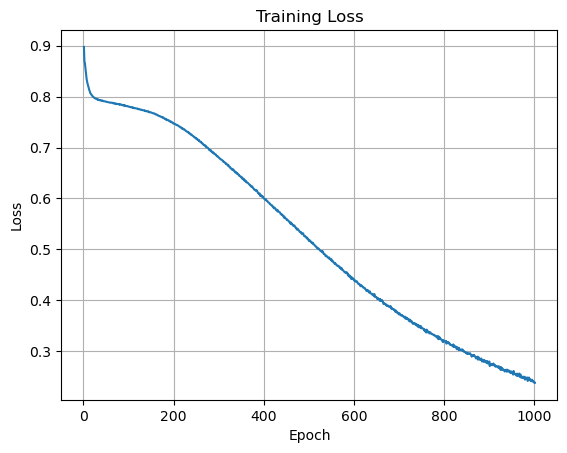

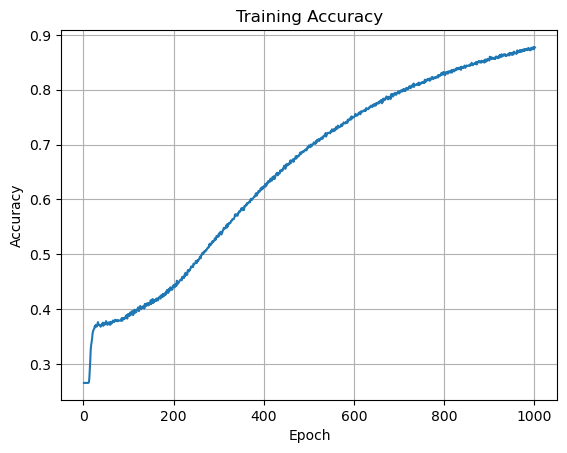

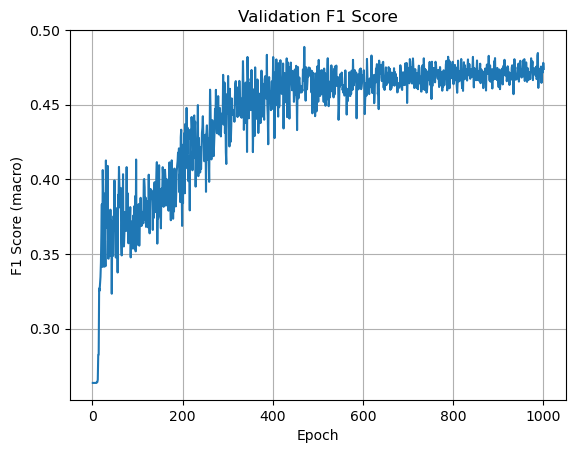

In [28]:
epochs = history["epoch"]

plt.figure()
plt.plot(epochs, history["train_loss"])
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss")
plt.grid(True)
plt.show()

plt.figure()
plt.plot(epochs, history["train_f1"])
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Training Accuracy")
plt.grid(True)
plt.show()

plt.figure()
plt.plot(epochs, history["val_f1"])
plt.xlabel("Epoch")
plt.ylabel("F1 Score (macro)")
plt.title("Validation F1 Score")
plt.grid(True)
plt.show()

In [29]:
test_dataset = GANTableDataset(filter_real_x[36000:], s_scaled[36000*50:])

In [30]:
test_loader = DataLoader(
    test_dataset,
    batch_size=64,
    shuffle=False
)

In [31]:
def predict(model, dataloader, device):
    model.eval()

    all_preds = []
    all_targets = []

    with torch.no_grad():
        for s, y in dataloader:
            s = s.to(device)
            y = y.to(device)

            logits = model(s)
            preds = logits.argmax(dim=1)

            all_preds.append(preds.cpu())
            all_targets.append(y.cpu())

    all_preds = torch.cat(all_preds).numpy()
    all_targets = torch.cat(all_targets).numpy()

    return all_preds, all_targets

In [32]:
y_pred, y_true = predict(model, test_loader, device)

In [33]:
from sklearn.metrics import accuracy_score, f1_score, classification_report

print("Test Accuracy:", accuracy_score(y_true, y_pred))
print("Test F1 (macro):", f1_score(y_true, y_pred, average="macro"))

print(classification_report(y_true, y_pred))

Test Accuracy: 0.58
Test F1 (macro): 0.39549166770171534
              precision    recall  f1-score   support

           0       0.24      0.23      0.23      1774
           1       0.21      0.24      0.22      1705
           2       0.74      0.72      0.73      8521

    accuracy                           0.58     12000
   macro avg       0.39      0.40      0.40     12000
weighted avg       0.59      0.58      0.58     12000

